In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

1. Предварительная обработка данных

Проверяем датасет (Всё нормализовано кроме столбцов с классами)

In [21]:
fraction = 1

In [22]:
# .sample(frac=0.1) - Для тестирования и быстроты работы возьмём только 10% от выборки
df = pd.read_csv('normalized_data.csv', encoding='ISO-8859-1').sample(frac=fraction, random_state=0)
df.head()

,year,price_in_euro,power_kw,power_ps,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,transmission_type,fuel_type
135641,0.642857,0.212011,0.164179,0.164634,0.007037,0.135135,0.039196,Automatic,Diesel
36995,0.214286,0.085066,0.227197,0.228049,0.013261,0.235235,0.071053,Automatic,Petrol
121769,0.821429,0.364362,0.175788,0.176829,0.008525,0.145145,0.011579,Manual,Petrol
70647,0.892857,0.874487,0.208955,0.209756,0.007307,0.143143,0.014605,Automatic,Diesel
9713,1.000000,0.770819,0.225539,0.225610,0.006360,0.138138,0.000276,Automatic,Diesel


a) Визуализация значимых признаков

Посмотрим возможные параметры для создания модели регресси (построения зависимости) (для упрощения визуализации возьмём два параметра)

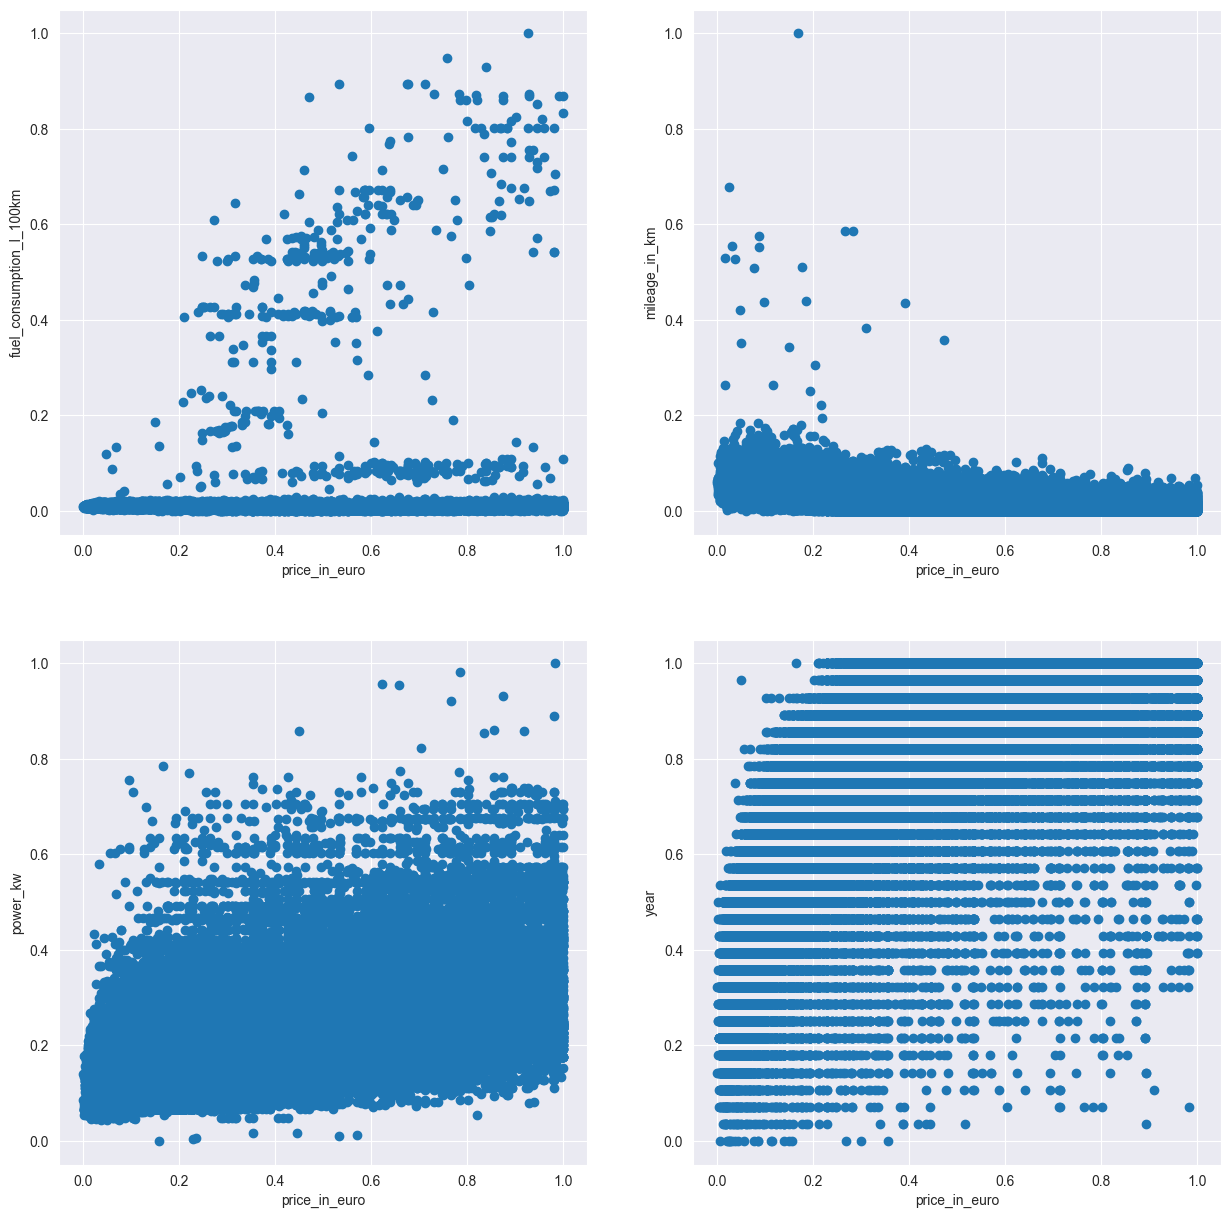

In [23]:
# Массив графиков 2 на 2, размер отображаемой картинки: 15 на 15
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
# Первый график рассеяния: стоимость и потребление топлива
ax[0][0].scatter(df["price_in_euro"], df["fuel_consumption_l_100km"])
ax[0][0].set_xlabel("price_in_euro")
ax[0][0].set_ylabel("fuel_consumption_l_100km")

# Второй график рассеяния: стоимость и пройденный километраж
ax[0][1].scatter(df["price_in_euro"], df["mileage_in_km"])
ax[0][1].set_xlabel("price_in_euro")
ax[0][1].set_ylabel("mileage_in_km")

# Второй график рассеяния: стоимость и мощность
ax[1][0].scatter(df["price_in_euro"], df["power_kw"])
ax[1][0].set_xlabel("price_in_euro")
ax[1][0].set_ylabel("power_kw")

# Второй график рассеяния: мощность и потребление топлива
ax[1][1].scatter(df["price_in_euro"], df["year"], label="f")
ax[1][1].set_xlabel("price_in_euro")
ax[1][1].set_ylabel("year")
plt.show()

Обратная зависимость прослеживается на графики с ценой и годом выпуска. Возьмём эти два параметра

In [24]:
df = df[["price_in_euro", "year"]]

b) Очистка данных

Определяем выбросы данных через квантили (на графике явно видно ненужные точки, которые могут помешать построению зависимости)

In [25]:
z = (df - df.mean()) / df.std()
df = df[(z < 3).all(axis=1)]

# Определяем выбросы с помощью квантилей
Q1 = df.quantile(0.05)
Q3 = df.quantile(0.95)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [26]:
x = df[["price_in_euro"]]
y = df[["year"]]

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

2. Обучение моделей и подбор параметров

a) Параметры для подобора для модели линейной регрессии

In [28]:
param_grid = {
    'positive': [True, False],
}

GridSearchCV для линейной регрессии

In [29]:
grid_search_lr = GridSearchCV(LinearRegression(), param_grid, cv=5, n_jobs=-1)
grid_search_lr.fit(x_train, y_train)
print(grid_search_lr.best_params_)

C:\Users\Admin\PycharmProjects\ML-Auto\venv\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'positive': True}


b) Параметры для подобора для модели регрессии лассо

In [30]:
param_grid = {
    'alpha': np.logspace(-4, 4, 9)  # Поиск значений альфа от 10^-4 до 10^4
}

GridSearchCV для регрессии лассо

In [31]:
grid_search_lasso = GridSearchCV(Lasso(), param_grid, cv=5, n_jobs=-1)
grid_search_lasso.fit(x_train, y_train)
print(grid_search_lasso.best_params_)

{'alpha': 0.0001}


c) Параметры для подобора для модели гребневая регрессия

In [32]:
param_grid = {
    'alpha': np.logspace(-3, 3, 7)
}

GridSearchCV для гребневой регрессии

In [33]:
grid_search_ridge = GridSearchCV(Ridge(), param_grid=param_grid, cv=5, n_jobs=-1)
grid_search_ridge.fit(x_train, y_train)
print(grid_search_ridge.best_params_)

{'alpha': 0.1}


 3. Оценка моделей

a) Вывод метрик

Записываем предсказания

In [34]:
y_pred_lr = grid_search_lr.predict(x_test)
y_pred_lasso = grid_search_lasso.predict(x_test)
y_pred_ridge = grid_search_ridge.predict(x_test)

Вычисляем метрику R-squared (Коэффициент детерминации)

In [35]:
linear_r2 = r2_score(y_test, y_pred_lr)
lasso_r2 = r2_score(y_test, y_pred_lasso)
ridge_r2 = r2_score(y_test, y_pred_ridge)

Вычисляем среднюю квадратичную ошибку (Mean Squared Error)

In [36]:
mse_lr = mean_squared_error(y_test, y_pred_lr)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

Выводим метрику R-squared (чем ближе к 1 тем лучше)

In [37]:
print("Linear R-squared: ", linear_r2)
print("Lasso R-squared: ", lasso_r2)
print("Ridge R-squared: ", ridge_r2)

Linear R-squared:  0.42044670409642704
Lasso R-squared:  0.4204375185563115
Ridge R-squared:  0.4204466934206298


Значение R-квадрата, равное 0,42, указывает на то, что приблизительно 42% дисперсии искомой переменной (y) объясняется данными переменными (x) в модели. Хотя универсального порога для "хорошего" R-квадрата не существует, значение 0,42 можно считать умеренным.

Выводим ошибку (чем меньше тем лучше)

In [38]:
print("Linear Regression MSE: ", mse_lr)
print("Lasso MSE: ", mse_lasso)
print("Ridge MSE: ", mse_ridge)

Linear Regression MSE:  0.020174532543840395
Lasso MSE:  0.0201748522969663
Ridge MSE:  0.020174532915470098


b) Построение графиков

Строим графики для моделей

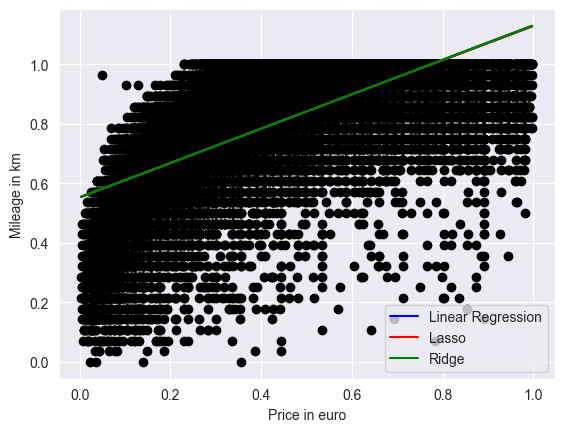

In [40]:
plt.scatter(x_test, y_test, color='black')
plt.plot(x_test, y_pred_lr, color='blue', label='Linear Regression')
plt.plot(x_test, y_pred_lasso, color='red', label='Lasso')
plt.plot(x_test, y_pred_ridge, color='green', label='Ridge')
plt.xlabel("Price in euro")
plt.ylabel("Mileage in km")
plt.legend()
plt.show()

Модели подтвердили обратную зависимсоть между параметрами - чем дешевле авто, тем раньше оно было выпущено (некоторые метрики могут показывать неудовлетворительный результат из-за большого разброса данных в приниципе, но в целом благодаря использован7ию всего двух параметров зависимость можно отследить по графику)

Линейная регрессия подходит, когда взаимосвязь между независимыми и зависимыми переменными линейна. Она работает путем нахождения наиболее подходящей линии, которая минимизирует сумму квадратов различий между наблюдаемыми и прогнозируемыми значениями.

Регрессия Лассо полезна при работе с наборами данных, содержащими большое количество объектов, поскольку она выполняет отбор объектов путем сокращения менее важных объектов до нуля. Lasso добавляет штрафной коэффициент к стандартной целевой функции линейной регрессии, что помогает предотвратить переобучение и улучшить интерпретируемость модели.

Гребневая регрессия полезна при наличии линейной зависимости между многими переменными, поскольку она добавляет штрафной коэффициент к стандартной целевой функции линейной регрессии, который уменьшает коэффициенты коррелированных переменных. Это помогает уменьшить влияние зависимость разных параметров и делает модель более надежной.

Таким образом, линейная регрессия идеально подходит для простых линейных зависимостей, регрессия лассо полезна для выбора признаков в больших наборах данных, а регрессия гребня полезна для работы с зависимостями между многими переменными